**Upload Data**

In [26]:
import torch.optim as optim
import torch

import numpy as np
import gzip


In [27]:
torch.manual_seed(42)

In [28]:
def training_images():
    with gzip.open('/content/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('/content/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [29]:
x_train = training_images()
x_train.shape

(60000, 28, 28)

In [30]:
y_train = training_labels()
y_train.shape

(60000,)

In [31]:
x_s = x_train.reshape(60000,784)
x_s.shape

(60000, 784)

convert to tensor

In [32]:
x_s=torch.tensor(x_s).type(torch.FloatTensor)
y_s=torch.tensor(y_train)

In [33]:
y_s.shape

torch.Size([60000])

**Softmax Regression**

In [247]:
class SoftmaxRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(SoftmaxRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         self.Softmax = torch.nn.Softmax(dim=1)
        
         self.dp = torch.nn.Dropout(p = 0.2)
         self.batch = torch.nn.BatchNorm1d(10)
     
     def forward(self, x):
         #x = self.dp(x)
         x = self.linear(x)
         #x = self.batch(x)
         outputs = self.Softmax(x)
         
         return outputs

**MLP**

In [34]:
class MLP(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(MLP, self).__init__()
         self.linear1 = torch.nn.Linear(input_dim, 256)
         self.linear2 = torch.nn.Linear(256, 256)
         self.linear3 = torch.nn.Linear(256, output_dim)
         
         self.ReLU = torch.nn.ReLU()
         self.Softmax = torch.nn.Softmax(dim=1)
         
         self.dp = torch.nn.Dropout(p = 0.2)
         self.batch = torch.nn.BatchNorm1d(256)

     def forward(self, x):
       
         x = self.linear1(x)
         #x = self.batch(x)
         x = self.ReLU(x)
         x = self.dp(x)

         x = self.linear2(x)
         #x = self.batch(x)
         x = self.ReLU(x)
         x = self.dp(x)

         x = self.linear3(x)
         #x = self.dp(x)
         outputs = self.Softmax(x)
         
         return outputs

parameteres

In [35]:
n_epochs = 300
input_dim = 784 
output_dim = 10  
learning_rate = 0.01
loss_model = torch.nn.CrossEntropyLoss()

model_MLP = MLP(input_dim,output_dim)
optimizer = torch.optim.SGD(model_MLP.parameters(), lr=learning_rate)

#model_SR = SoftmaxRegression(input_dim,output_dim)
#optimizer = torch.optim.SGD(model_SR.parameters(), lr=learning_rate)



In [36]:
torch.cuda.is_available()

False

In [37]:
train_losses = []
train_counter = []

In [38]:
train_predict=[]
for epoch in range(1, n_epochs+1):

    ############# choose the model: SR--> softmax regression , MLP--> MLP
    #model_SR.train()
    model_MLP.train()
    
    optimizer.zero_grad()

    ############# choose the model: SR--> softmax regression , MLP--> MLP
    #output = model_SR(x_s)
    output = model_MLP(x_s)

    loss = loss_model(output, y_s)

    loss.backward()
    optimizer.step()
    #print(epoch)
    train_predict.append(output)

    train_losses.append(loss)
    train_counter.append(epoch)


In [39]:
def classlabel(l):
    return l.argmax(axis=1)

In [40]:
len(train_predict)

300

Accuracy of Train

In [41]:
accuracy=[]
for j in range(len(train_predict)):
    count = 0
    predict = classlabel(train_predict[j])

    for k in range(len(predict)):
        if predict[k] == y_s[k]:
             count+= 1
    
    accuracy.append(count/len(predict))
print("Train Accuracy: ",count/len(predict))

Train Accuracy:  0.8168333333333333


Plot-Accuracy

Text(0.5, 1.0, 'MLP - dropout')

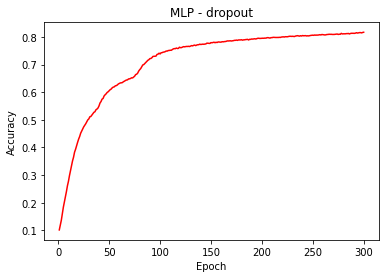

In [42]:
import matplotlib.pyplot as plt
plt.plot(train_counter, accuracy, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP - dropout')

Plot-Loss

Text(0.5, 1.0, 'MLP - dropout')

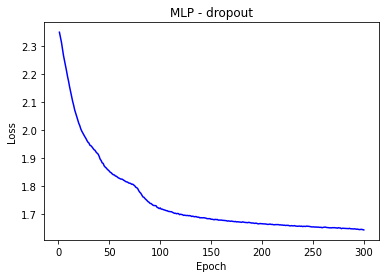

In [43]:
import matplotlib.pyplot as plt
loss_list = []

for i in range (len(train_losses)):
  loss_list.append(float(train_losses[i]))

plt.plot(train_counter, loss_list, color='blue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP - dropout')

Test dataset

In [44]:
def testing_images():
    with gzip.open('/content/t10k-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def testing_labels():
    with gzip.open('/content/t10k-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [45]:
x_test = testing_images()
x_test.shape

(10000, 28, 28)

In [46]:
y_test = testing_labels()
y_test.shape

(10000,)

In [47]:
x_st = x_test.reshape(10000,784)

In [48]:
x_st=torch.tensor(x_st).type(torch.FloatTensor)
y_st=torch.tensor(y_test)

In [49]:
def test():

  ############# choose the model: SR--> softmax regression , MLP--> MLP
  #model_SR.eval()
  model_MLP.eval()

  ############# choose the model: SR--> softmax regression , MLP--> MLP
  #output = model_SR(x_st)
  output = model_MLP(x_st)

  y_predict = classlabel(output) 
  correct = 0
  for k in range(len(y_predict)):
    
    if y_predict[k] == y_test[k]:
      correct+= 1

  print("Test Accuracy: ",correct/len(y_test))

In [50]:
test()

Test Accuracy:  0.8518
